# Music Genre Classification
In this notebook I tried to learn the basic concepts of neural networks and use it to classify the music files in dataset. Majorly this notebook can be divided into 3 parts:

   1) Using ANN 

   2) Tackling overfitting with ANN

   3) Using CNN


Also to read the dataset I have used librosa library which only read files <1Mb and one file is greater than the size giving error due to which I have ignored it. The dataset contains the following genres, the keys being the prediction targets
    
    0: "disco",
    1: "metal",
    2: "reggae",
    3: "blues",
    4: "rock",
    5: "classical",
    6: "jazz",
    7: "hiphop",
    8: "country",
    9: "pop"


In [1]:
import os
import librosa
import math
import json 
import matplotlib.pyplot as plt
import numpy as np

In [2]:
dataset_path = r"../input/gtzan-dataset-music-genre-classification/Data/genres_original"
json_path = r"data.json"
SAMPLE_RATE = 22050
DURATION = 30
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION

In [3]:
def save_mfcc(dataset_path, json_path, n_mfcc=13, n_fft=2048,
             hop_length=512, num_segments=5):
    # Data storage dictionary
    data = {
        "mapping": [],
        "mfcc": [],
        "labels": [],
    }
    samples_ps = int(SAMPLES_PER_TRACK/num_segments) # ps = per segment
    expected_vects_ps = math.ceil(samples_ps/hop_length)
    
    # loop through all the genres
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        # ensuring not at root
        if dirpath is not dataset_path:
            # save the semantic label
            dirpath_comp = dirpath.split("/")
            semantic_label = dirpath_comp[-1]
            data["mapping"].append(semantic_label)
            print(f"Processing: {semantic_label}")
            
            # process files for specific genre
            for f in filenames:
                if(f==str("jazz.00054.wav")):
                    # As librosa only read files <1Mb
                    continue
                else:
                    # load audio file
                    file_path = os.path.join(dirpath, f)
                    signal,sr = librosa.load(file_path,sr=SAMPLE_RATE)
                    for s in range(num_segments):
                        start_sample = samples_ps * s
                        finish_sample = start_sample + samples_ps

                        mfcc = librosa.feature.mfcc(signal[start_sample:finish_sample],
                                                    sr = sr,
                                                    n_fft = n_fft,
                                                    n_mfcc = n_mfcc,
                                                    hop_length = hop_length)

                        mfcc = mfcc.T

                        # store mfcc if it has expected length 
                        if len(mfcc)==expected_vects_ps:
                            data["mfcc"].append(mfcc.tolist())
                            data["labels"].append(i-1)
                            print(f"{file_path}, segment: {s+1}")

    with open(json_path,"w") as f:
        json.dump(data,f,indent=4)

In [4]:
from IPython.display import clear_output

In [5]:
filepath = r"../input/gtzan-dataset-music-genre-classification/Data/genres_original/blues/blues.0000"

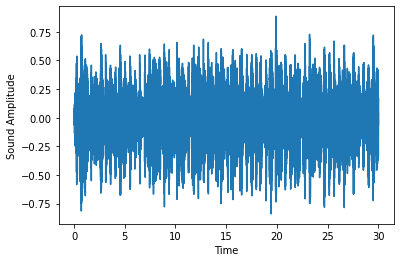

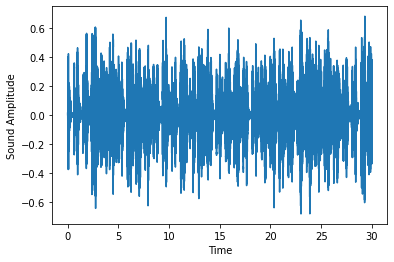

In [6]:
for i in range(2):
    audio, sfreq = librosa.load(filepath+str(i)+".wav")
    time = np.arange(0, len(audio))/sfreq
    plt.plot(time,audio)
    plt.xlabel("Time")
    plt.ylabel("Sound Amplitude")
    plt.show()

# Classifier
This part uses the concepts of ANN with keras and sequential layers. I have also done splitting in the ratio 70:30

The model is Sequential and architecture only has Flatten and the Dense layers available in keras for the basic ANN representation. As it is naive model we can expect it to be overfit. Info on the layers can be found here


In [7]:
import json
import numpy as np

In [8]:
# load data
def load_data(dataset_path):
    with open(dataset_path,"r") as f:
        data = json.load(f)
    
    # Convert list to numpy arrays
    inputs = np.array(data["mfcc"])
    targets = np.array(data["labels"])    
    
    return inputs,targets

In [9]:
inputs,targets = load_data(r"./data.json")

FileNotFoundError: [Errno 2] No such file or directory: './data.json'

In [ ]:
# splitting the data
from sklearn.model_selection import train_test_split

input_train, input_test, target_train, target_test = train_test_split(inputs, targets, test_size=0.3)
print(input_train.shape, target_train.shape)

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *

In [ ]:
model = Sequential()

model.add(Flatten(input_shape=(inputs.shape[1],inputs.shape[2])))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.summary()

In [ ]:
from tensorflow.keras import optimizers
adam = optimizers.Adam(lr=1e-4)

In [ ]:
model.compile(optimizer=adam,
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])

In [ ]:
model.compile(optimizer=adam,
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])

hist = model.fit(input_train, target_train,
                 validation_data = (input_test,target_test),
                 epochs = 50,
                 batch_size = 32)
clear_output()

In [ ]:
def plot_history(hist):
    plt.figure(figsize=(20,15))
    fig, axs = plt.subplots(2)
    # accuracy subplot
    axs[0].plot(hist.history["accuracy"], label="train accuracy")
    axs[0].plot(hist.history["val_accuracy"], label="test accuracy")    
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")
    
    # Error subplot
    axs[1].plot(hist.history["loss"], label="train error")
    axs[1].plot(hist.history["val_loss"], label="test error")    
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")
    
    plt.show()

In [ ]:
plot_history(hist)

In [ ]:
test_error, test_accuracy = model.evaluate(input_test, target_test, verbose=1)
print(f"Test accuracy: {test_accuracy}")

# Overfitting

In [ ]:
import tensorflow.keras as keras

In [ ]:
# Overfitting
model = Sequential()

model.add(Flatten(input_shape=(inputs.shape[1],inputs.shape[2])))
model.add(Dense(512, activation='relu', kernel_regularizer = keras.regularizers.l2(0.001)))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu', kernel_regularizer = keras.regularizers.l2(0.003)))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu', kernel_regularizer = keras.regularizers.l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.summary()

In [ ]:
model.compile(optimizer=adam,
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])

hist = model.fit(input_train, target_train,
                 validation_data = (input_test,target_test),
                 epochs = 50,
                 batch_size = 32)

clear_output()

In [ ]:
plot_history(hist)

In [ ]:
test_error, test_accuracy = model.evaluate(input_test, target_test, verbose=1)
print(f"Test accuracy: {test_accuracy}")

 # CNN

In [ ]:
def prepare_dataset(test_size, validation_size):
    X,y = load_data(r"./data.json")
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = validation_size)
    X_train = X_train[..., np.newaxis]
    X_val = X_val[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_val, X_test, y_train, y_val, y_test

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = prepare_dataset(0.25, 0.2)

In [ ]:
input_shape = (X_train.shape[1],X_train.shape[2],X_train.shape[3])
print(input_shape)

In [ ]:
model = Sequential()
model.add(Conv2D(64, (3, 3), activation = "relu", input_shape = input_shape))
model.add(MaxPool2D((3, 3), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Conv2D(32, (3, 3), activation = "relu"))
model.add(MaxPool2D((3, 3), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Conv2D(32, (2, 2), activation = "relu"))
model.add(MaxPool2D((2, 2), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Conv2D(16, (1, 1), activation = "relu"))
model.add(MaxPool2D((1, 1), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(10, activation="softmax"))

model.summary()

In [ ]:
model.compile(optimizer=adam,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

hist = model.fit(X_train, y_train,
                 validation_data = (X_val, y_val),
                 epochs = 40,
                 batch_size = 32)

In [ ]:
plot_history(hist)

In [ ]:
test_error, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test accuracy: {test_accuracy}")

In [ ]:
def predict(model, X, y):
    X = X[np.newaxis,...]
    prediction = model.predict(X)
    predicted_index = np.argmax(prediction, axis=1)
    print(f"Expected index: {y}, Predicted index: {predicted_index}")

In [ ]:
predict(model, X_test[10], y_test[10])